In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [17]:
import numpy as np
import pandas as pd

In [18]:
import datetime as dt
from datetime import date
from datetime import timedelta
import scipy.stats as st

# Reflect Tables into SQLAlchemy ORM

In [40]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [9]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
base=automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [21]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement=base.classes.measurement
Station=base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [25]:
session.query(Measurement.date).limit(5).all()

[('2010-01-01'),
 ('2010-01-02'),
 ('2010-01-03'),
 ('2010-01-04'),
 ('2010-01-06')]

In [26]:
session.query(Station.station).limit(5).all()

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838')]

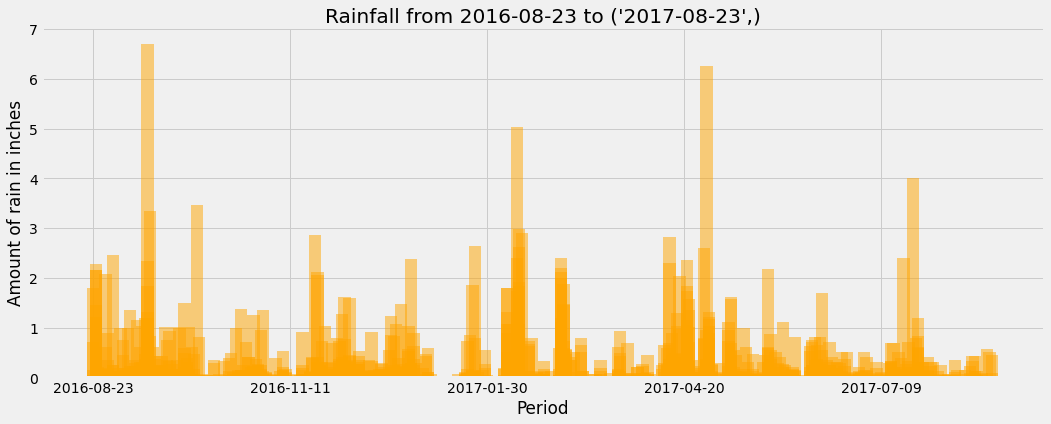

In [28]:
#latest entry
earliest=session.query(Measurement.date).order_by(Measurement.date).first()
latest=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#print(f"earliest:{earliest[0]},latest:{latest[0]}")

# Design a query to retrieve the last 12 months of precipitation data and plot the results
#first conv of latest date to dt(py)


# Calculate the date 1 year ago from the last data point in the database
lyq=date.fromisoformat(latest[0])-timedelta(365)
#print(lyq)
# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=lyq).all()
#print(results)
# Save the query results as a Pandas DataFrame and set the index to the date column
precipt_df=pd.DataFrame(results)
#precept_df.head()
#Sort the dataframe by date
precipt_df=precipt_df.sort_values(["date"],ascending=True)
#df.info drop na.
#precept_df.info()
precipt_df=precipt_df.dropna()
precipt_df=precipt_df.set_index("date")
#prcp_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
hor=precipt_df.index.tolist()
ver=precipt_df['prcp'].tolist()
plt.figure(figsize=(16,6))
plt.bar(hor,ver,width=5,color='orange',alpha=.5,align="center",label=precipt_df)
plt.tick_params(axis='x',which='both',bottom=True,top=True,labelbottom=True)
major_ticks=np.arange(0,400,80)
plt.xticks(major_ticks)
plt.title(f"Rainfall from {lyq} to {latest}") 
plt.xlabel("Period")
plt.ylabel("Amount of rain in inches")
#plt.legend()
plt.show()





In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipt_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [31]:
# Design a query to show how many stations are available in this dataset?
stations=session.query(Station.id).count()
print(f'Total stations = {stations}')

Total stations = 9


In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
actst=session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
actst
print(f' Station {actst[0][0]} is the most active with {actst[0][1]} measurements')

 Station USC00519281 is the most active with 2772 measurements


In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temps=[func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
actsttemps=session.query(*temps).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
actsttemps
# print(f'The temperatures for station {actst[0][0]} are: Lowest:{actsttemps[0][0]}, average:{actsttemps[0][1]}, Highest:{actsttemps[0][2]}')

(54.0, 71.66378066378067, 85.0)

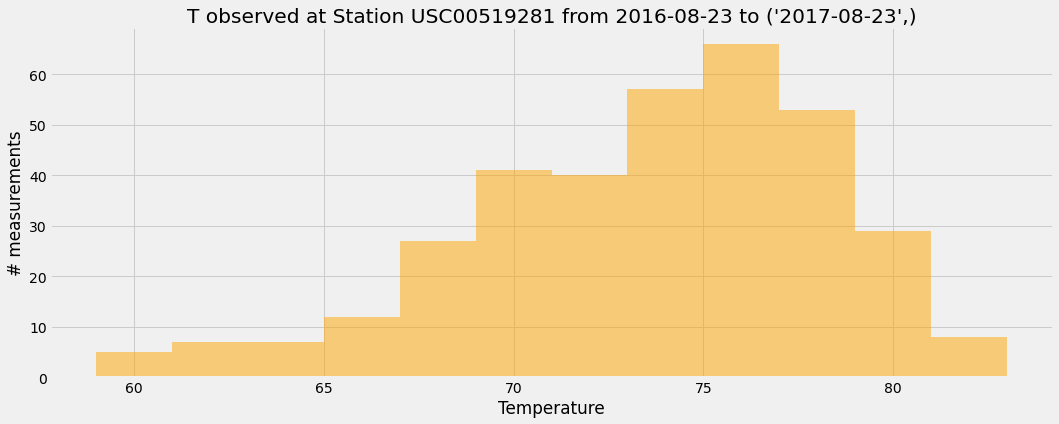

In [38]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
statobs12mo=session.query(Measurement.tobs).filter(Measurement.station==actst[0][0]).filter(Measurement.date>=lyq).all()  #(temperatures=list(np.ravel(statobs12mo)) different way to do the same)
#statobs12mo
#len(statobs12mo)
statobs12mo_list=[tobs[0]for tobs in statobs12mo]
plt.figure(figsize=(16,6))
plt.hist(statobs12mo_list, bins=12, color='orange', rwidth=1.0, alpha=.5, align="mid")
plt.ylabel('# measurements')
plt.xlabel('Temperature')
plt.title(f"T observed at Station {actst[0][0]} from {lyq} to {latest}")
plt.show()

## Bonus Challenge Assignment

In [107]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [108]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [109]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [110]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [111]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [112]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [113]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [114]:
# Plot the daily normals as an area plot with `stacked=False`
